In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
epochs = 100
batch_size = 48
testsplit = .5
targetx = 128
targety = 128
learning_rate = 0.0001
classes = 7
seed = random.randint(1, 1000)
target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

data_dir = "/kaggle/input/fer2013/train/"
data_dir1 = "/kaggle/input/fer2013/test/"

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       
)
val_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="training"
        
)

test_generator = test_datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
    subset="validation",
        seed=seed
)

Found 28709 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.


/kaggle/input/fer2013/train/surprise/Training_57994832.jpg


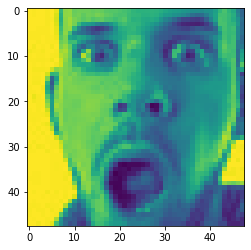

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('ensambleModel.tf',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

2023-01-24 04:57:52.493783: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 04:57:52.493822: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-24 04:57:52.613950: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2023-01-24 04:57:52.663706: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 04:57:52.663858: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [6]:
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [7]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/kaggle/input/ens-densenet/DenseNet121.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')

model_2 = load_model('/kaggle/input/ens-densenet/DenseNet169.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/kaggle/input/ens-densenet/DenseNet201.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2,model_3]
model_input = Input(shape=(targetx, targety, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()


2023-01-24 04:57:53.197179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:57:53.198316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:57:53.335242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:57:53.336136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 04:57:53.336903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
name_of_model_1 (Functional)    (None, 7)            7702599     input_1[0][0]                    
__________________________________________________________________________________________________
name_of_model_2 (Functional)    (None, 7)            13638215    input_1[0][0]                    
__________________________________________________________________________________________________
name_of_model_3 (Functional)    (None, 7)            19449415    input_1[0][0]                    
___________________________________________________________________________________________

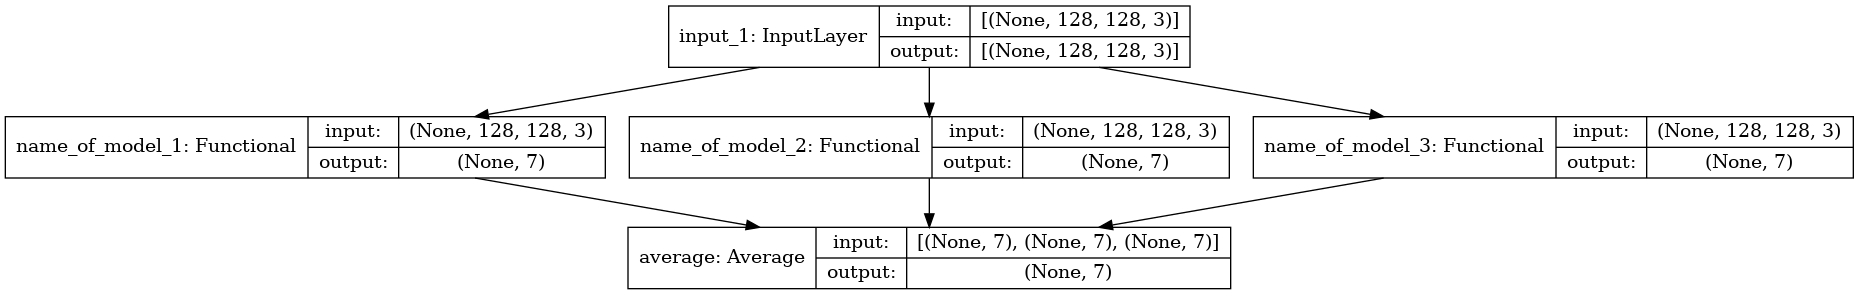

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [9]:
%%time

model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Beginning training
Epoch 1/100
Learning rate:  1e-04


2023-01-24 04:58:27.457986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-24 04:59:20.532521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/599 [..............................] - ETA: 11:12:10 - loss: 0.5760 - accuracy: 0.9792

2023-01-24 04:59:34.947832: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-24 04:59:34.947896: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/599 [..............................] - ETA: 19:04 - loss: 0.5112 - accuracy: 0.9896   

2023-01-24 04:59:36.871282: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-24 04:59:36.881434: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-24 04:59:37.223292: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 12240 callback api events and 12237 activity events. 
2023-01-24 04:59:37.594537: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-24 04:59:38.029671: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs-01242023045752/train/plugins/profile/2023_01_24_04_59_37

2023-01-24 04:59:38.363388: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs-01242023045752/train/plugins/profile/2023_01_24_04_59_37/b07da00b5be9.trace.json.gz
2023-01-24 04:59:39.066109: I tensorflow/core/profiler/rpc/client/save_profile.cc:13

599/599 [==============================] - 572s 844ms/step - loss: 0.5760 - accuracy: 0.9257 - val_loss: 1.3892 - val_accuracy: 0.6831
End of epoch 0. Learning rate: 1e-04

Epoch 00001: val_accuracy improved from -inf to 0.68310, saving model to ensambleModel.tf


2023-01-24 05:09:37.510532: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
Learning rate:  1e-04
599/599 [==============================] - 488s 814ms/step - loss: 0.5684 - accuracy: 0.9090 - val_loss: 1.3716 - val_accuracy: 0.6814
End of epoch 1. Learning rate: 1e-04

Epoch 00002: val_accuracy did not improve from 0.68310
Epoch 3/100
Learning rate:  1e-04
599/599 [==============================] - 503s 840ms/step - loss: 0.5733 - accuracy: 0.8940 - val_loss: 1.3290 - val_accuracy: 0.6953
End of epoch 2. Learning rate: 1e-04

Epoch 00003: val_accuracy improved from 0.68310 to 0.69535, saving model to ensambleModel.tf
Epoch 4/100
Learning rate:  1e-04
599/599 [==============================] - 503s 839ms/step - loss: 0.5360 - accuracy: 0.8985 - val_loss: 1.3082 - val_accuracy: 0.6845
End of epoch 3. Learning rate: 1e-04

Epoch 00004: val_accuracy did not improve from 0.69535
Epoch 5/100
Learning rate:  1e-04
599/599 [==============================] - 506s 844ms/step - loss: 0.5367 - accuracy: 0.8938 - val_loss: 1.3361 - val_accuracy: 0.6873
End of 

In [10]:
history = pd.DataFrame(model_history.history)
history.to_csv('ensambleModel.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,0.575989,0.925738,1.389150,0.683097,1.000000e-04
1,0.568447,0.909018,1.371622,0.681426,1.000000e-04
2,0.573347,0.894005,1.328992,0.695350,1.000000e-04
3,0.536049,0.898534,1.308237,0.684489,1.000000e-04
4,0.536686,0.893796,1.336057,0.687274,1.000000e-04
5,0.488974,0.902226,1.346953,0.692286,1.000000e-04
6,0.483193,0.899161,1.339773,0.687274,1.000000e-04
7,0.490517,0.893831,1.261933,0.690615,1.000000e-04
8,0.369716,0.932634,1.308291,0.713450,3.162277e-05
9,0.323434,0.944164,1.293427,0.718741,3.162277e-05


<h2>Plotting<h2>

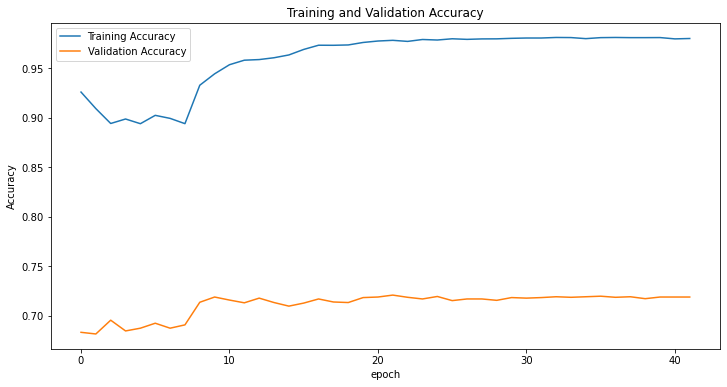

In [11]:
f, ax=plt.subplots(figsize=(12,6))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

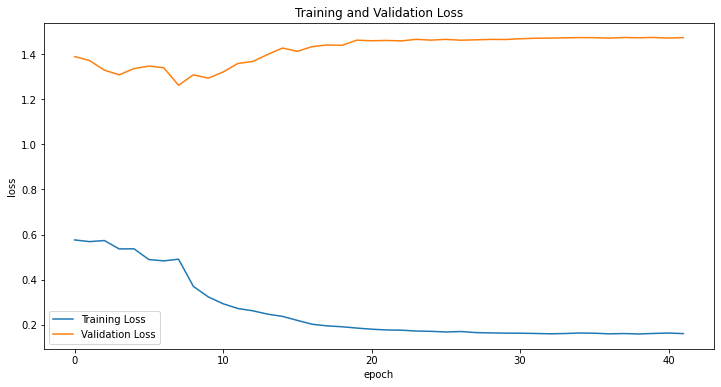

In [12]:
f, ax=plt.subplots(figsize=(12,6))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()


<h2>Model Evaluation<h2>

In [13]:
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

       angry       0.66      0.67      0.66       479
     disgust       0.84      0.69      0.76        55
        fear       0.64      0.56      0.60       512
       happy       0.91      0.91      0.91       887
     neutral       0.68      0.73      0.70       616
         sad       0.61      0.64      0.62       623
    surprise       0.86      0.82      0.84       415

    accuracy                           0.74      3587
   macro avg       0.74      0.72      0.73      3587
weighted avg       0.74      0.74      0.74      3587



In [14]:
#confusion matrix
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=test_generator.classes


from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

array([[319,   4,  46,  12,  36,  57,   5],
       [ 11,  38,   2,   1,   2,   0,   1],
       [ 52,   2, 289,  11,  43,  92,  23],
       [ 10,   0,   9, 811,  25,  16,  16],
       [ 27,   1,  27,  22, 451,  86,   2],
       [ 48,   0,  55,  17,  97, 399,   7],
       [ 16,   0,  26,  17,  10,   6, 340]])

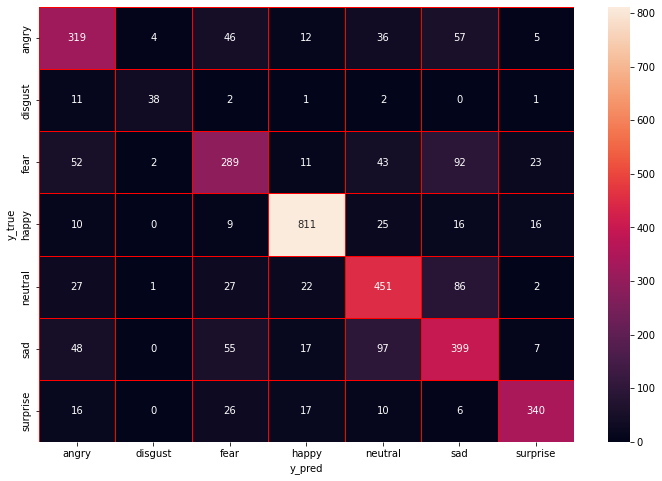

In [15]:
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax,xticklabels=target_names, yticklabels=target_names,)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [16]:
model.evaluate(test_generator , verbose = 0)

[1.306830883026123, 0.7379425764083862]